## Subscription Data

Author: Vivian

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [122]:
sub = pd.read_csv('/Users/vivianyan/Desktop/Fall2024/1006/Capstone/Data/XYZ_NETWORKS_SUB_1P_DATA.csv')
sub.describe(include='all')

,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE
count,219218,250000,250000,250000,250000.000000,250000
unique,46247,5,4,3,NaN,730
top,301TUHW316,CineQuest,paid,monthly,NaN,2022-12-29
freq,28,74818,124780,162765,NaN,396
mean,NaN,NaN,NaN,NaN,31.133457,NaN
std,NaN,NaN,NaN,NaN,28.574427,NaN
min,NaN,NaN,NaN,NaN,2.400000,NaN
25%,NaN,NaN,NaN,NaN,11.990000,NaN
50%,NaN,NaN,NaN,NaN,20.000000,NaN
75%,NaN,NaN,NaN,NaN,49.990000,NaN


In [123]:
sub.head()

,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE
0,042MSTJ610,CineQuest,trial,monthly,11.41,2022-10-09
1,020TBXH154,ChillStream,paid,monthly,25.00,2022-08-04
2,367MQHB590,Pulse,paid,monthly,8.01,2023-08-10
3,805HIRQ868,RetroReel,expired,annual,119.99,2023-11-05
4,150UITM842,LimeLight,paid,monthly,20.02,2022-03-02


### Data Cleaning
Fix Incorrectly Imputed `daily` Values:
<div class="alert alert-info">
Daily is an incorrectly imputed value for monthly. The only two valid values for term should be annual or monthly.
</div>

In [124]:
sub.TERM.unique()

array(['monthly', 'annual', 'daily'], dtype=object)

In [125]:
sub['TERM'] = sub['TERM'].replace('daily', 'monthly')
sub.TERM.unique()

array(['monthly', 'annual'], dtype=object)

Ensure No Duplicate Events per ID/Brand per Month:
<div class="alert alert-info">
No ID should have 2 events in the same month within a specific brand 

- This can be determined using the partition date field
</div>

In [126]:
sub['YEAR_MONTH'] = pd.to_datetime(sub['PARTITION_DATE']).dt.to_period('M')
sub.head()

,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE,YEAR_MONTH
0,042MSTJ610,CineQuest,trial,monthly,11.41,2022-10-09,2022-10
1,020TBXH154,ChillStream,paid,monthly,25.00,2022-08-04,2022-08
2,367MQHB590,Pulse,paid,monthly,8.01,2023-08-10,2023-08
3,805HIRQ868,RetroReel,expired,annual,119.99,2023-11-05,2023-11
4,150UITM842,LimeLight,paid,monthly,20.02,2022-03-02,2022-03


In [127]:
sub.groupby(['ID', 'YEAR_MONTH', 'BRAND']).agg({'SUB_STATUS':'count'})['SUB_STATUS'].nunique()

1

In [128]:
sub.groupby(['ID', 'YEAR_MONTH', 'BRAND']).agg({'TERM':'count'})['TERM'].nunique()

1

In [129]:
# sub.drop_duplicates(subset=['ID', 'BRAND', 'MONTH_YEAR'], inplace=True)

Validate Allowed Transitions Between States:
<div class="alert alert-info">
Transition states will be relevant to SUB_STATUS and TERM columns

- Allowed states for SUB_STATUS:	 
    - trial: paid, expired
    - discounted: paid, expired
    - paid: expired
    - expired: paid, discounted, trial

- An ID who is trial/discounted/paid for one term type (monthly/annual) will need to expire before they can begin a new subscription with the alternative term type
    - i.e. if a sub for Y brand is paid/monthly, and then the next chronological row indicates they are trial/annual, this second transition should be flagged as incorrect and ignored from subscription duration and other calculations 

If data is missing between partition date events for an individual, you can assume there status has remained unchanged/the same until the next valid transition 
</div>

In [130]:
allowed_transitions = {
    'trial': ['paid', 'expired'],
    'discounted': ['paid', 'expired'],
    'paid': ['expired'],
    'expired': ['paid', 'discounted', 'trial']
}

In [131]:
sub = sub.sort_values(by=['ID', 'BRAND', 'PARTITION_DATE']).reset_index(drop=True)
sub['VALID_TRANSITION'] = True

In [132]:
sub[sub.ID=='000AHHU956']

,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE,YEAR_MONTH,VALID_TRANSITION
0,000AHHU956,RetroReel,expired,monthly,30.00,2022-02-17,2022-02,True
1,000AHHU956,RetroReel,paid,monthly,29.99,2022-05-21,2022-05,True
2,000AHHU956,RetroReel,paid,monthly,30.00,2022-08-25,2022-08,True
3,000AHHU956,RetroReel,trial,monthly,28.01,2023-03-09,2023-03,True
4,000AHHU956,RetroReel,paid,monthly,30.02,2023-07-08,2023-07,True
5,000AHHU956,RetroReel,expired,monthly,30.00,2023-10-28,2023-10,True
6,000AHHU956,RetroReel,trial,monthly,11.18,2023-11-05,2023-11,True
7,000AHHU956,RetroReel,discounted,monthly,25.89,2023-12-27,2023-12,True


In [133]:
sub[sub.ID=='000DJKK225']

,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE,YEAR_MONTH,VALID_TRANSITION
11,000DJKK225,CineQuest,expired,monthly,12.00,2022-04-15,2022-04,True
12,000DJKK225,CineQuest,expired,monthly,12.00,2022-06-21,2022-06,True
13,000DJKK225,CineQuest,paid,monthly,12.00,2022-07-17,2022-07,True
14,000DJKK225,CineQuest,paid,monthly,11.97,2022-10-15,2022-10,True
15,000DJKK225,CineQuest,paid,annual,60.00,2023-09-29,2023-09,True


In [134]:
sub[sub.ID=='042MSTJ610']

,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE,YEAR_MONTH,VALID_TRANSITION
9307,042MSTJ610,CineQuest,expired,annual,59.99,2022-01-29,2022-01,True
9308,042MSTJ610,CineQuest,paid,annual,60.01,2022-02-06,2022-02,True
9309,042MSTJ610,CineQuest,paid,annual,59.99,2022-08-26,2022-08,True
9310,042MSTJ610,CineQuest,trial,monthly,11.41,2022-10-09,2022-10,True
9311,042MSTJ610,CineQuest,expired,monthly,12.00,2022-11-16,2022-11,True


<div class="alert alert-danger" role="alert">
Questions:

For user 000AHHU956:
1. row2 to row3: status remained unchanged?
2. last row: no closure, status remained unchanged? any deadline or until now?

For user 042MSTJ610:
1. row1 and row2: paid after expired?
2. row-2 to row-1: can we skip "paid"? or should be strictly followed by the assigend transition table except for "expired"?

For user 000DJKK225:
1. row1 and row2: two expires?
</div>

#### Test

In [135]:
test2 = sub.iloc[100:130].reset_index(drop=True)
test2

,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE,YEAR_MONTH,VALID_TRANSITION
0,000SJSR665,Pulse,paid,monthly,8.00,2023-05-28,2023-05,True
1,000SJSR665,Pulse,trial,monthly,5.30,2023-10-19,2023-10,True
2,000SJSR665,Pulse,paid,monthly,8.00,2023-11-11,2023-11,True
3,000TFKR237,RetroReel,paid,annual,119.99,2022-03-10,2022-03,True
4,000TMFK922,CineQuest,expired,annual,60.00,2022-11-22,2022-11,True
5,000TMFK922,CineQuest,paid,monthly,12.00,2022-12-24,2022-12,True
6,000TMFK922,CineQuest,expired,monthly,11.99,2023-12-17,2023-12,True
7,000TMFK922,Pulse,paid,annual,50.01,2022-02-14,2022-02,True
8,000TMFK922,Pulse,paid,annual,50.00,2022-07-12,2022-07,True
9,000TMFK922,Pulse,paid,annual,49.99,2023-01-22,2023-01,True


In [136]:
# Validate transitions for each user within each brand
prev, curr = 0, 1
while curr < len(test2):    
    print(prev, curr)
    if test2.iloc[curr]['ID'] == test2.iloc[prev]['ID'] and test2.iloc[curr]['BRAND'] == test2.iloc[prev]['BRAND']:
        prev_status, curr_status = test2.iloc[prev]['SUB_STATUS'], test2.iloc[curr]['SUB_STATUS']
        prev_term, curr_term = test2.iloc[prev]['TERM'], test2.iloc[curr]['TERM']

        if curr_status != allowed_transitions[prev_status][0] and prev_status != 'expired':
            test2.at[curr, 'VALID_TRANSITION'] = False
            curr += 1
            continue

        if curr_term != prev_term and prev_status != 'expired':
            test2.at[curr, 'VALID_TRANSITION'] = False
            curr += 1
            continue

        if curr_term == prev_term and curr_status == prev_status and prev_status == 'expired':
            test2.at[prev, 'VALID_TRANSITION'] = False

        prev = curr
        curr += 1

    else:
        prev = curr
        curr += 1

test2

0 1
0 2
0 3
3 4
4 5
5 6
6 7
7 8
7 9
7 10
10 11
11 12
12 13
13 14
14 15
15 16
15 17
17 18
18 19
18 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
27 29


,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE,YEAR_MONTH,VALID_TRANSITION
0,000SJSR665,Pulse,paid,monthly,8.00,2023-05-28,2023-05,True
1,000SJSR665,Pulse,trial,monthly,5.30,2023-10-19,2023-10,False
2,000SJSR665,Pulse,paid,monthly,8.00,2023-11-11,2023-11,False
3,000TFKR237,RetroReel,paid,annual,119.99,2022-03-10,2022-03,True
4,000TMFK922,CineQuest,expired,annual,60.00,2022-11-22,2022-11,True
5,000TMFK922,CineQuest,paid,monthly,12.00,2022-12-24,2022-12,True
6,000TMFK922,CineQuest,expired,monthly,11.99,2023-12-17,2023-12,True
7,000TMFK922,Pulse,paid,annual,50.01,2022-02-14,2022-02,True
8,000TMFK922,Pulse,paid,annual,50.00,2022-07-12,2022-07,False
9,000TMFK922,Pulse,paid,annual,49.99,2023-01-22,2023-01,False


### Validation

In [137]:
# Validate transitions for each user within each brand
prev, curr = 0, 1
while curr < len(sub):    
    if sub.iloc[curr]['ID'] == sub.iloc[prev]['ID'] and sub.iloc[curr]['BRAND'] == sub.iloc[prev]['BRAND']:
        prev_status, curr_status = sub.iloc[prev]['SUB_STATUS'], sub.iloc[curr]['SUB_STATUS']
        prev_term, curr_term = sub.iloc[prev]['TERM'], sub.iloc[curr]['TERM']

        if curr_status != allowed_transitions[prev_status][0] and prev_status != 'expired':
            sub.at[curr, 'VALID_TRANSITION'] = False
            curr += 1
            continue

        if curr_term != prev_term and prev_status != 'expired':
            sub.at[curr, 'VALID_TRANSITION'] = False
            curr += 1
            continue

        if curr_term == prev_term and prev_status == 'expired' and curr_status == 'expired':
            sub.at[prev, 'VALID_TRANSITION'] = False

        prev = curr
        curr += 1

    else:
        prev = curr
        curr += 1

In [138]:
sub_filtered = sub[sub['VALID_TRANSITION'] == True]
sub_filtered.dropna(how='any', inplace=True)
sub_filtered.describe(include='all')

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_23744/4147286684.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_filtered.dropna(how='any', inplace=True)


,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE,YEAR_MONTH,VALID_TRANSITION
count,131141,131141,131141,131141,131141.000000,131141,131141,131141
unique,46247,5,4,2,NaN,730,24,1
top,987EACZ999,CineQuest,paid,monthly,NaN,2022-01-28,2022-01,True
freq,15,33298,65789,93572,NaN,312,8865,131141
mean,NaN,NaN,NaN,NaN,32.868309,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,29.808195,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,2.410000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,12.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,20.010000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,49.990000,NaN,NaN,NaN


In [139]:
print('Filtered SUB Data Shape: ', sub_filtered.shape)
print('SUB Data Shape: ', sub.shape)

Filtered SUB Data Shape:  (131141, 8)
SUB Data Shape:  (250000, 8)


Calculate subcription duratino based on valid transitions:
<div class="alert alert-info">
Subscription start and end date are not provided. Instead partition date (symbolizes when data is refreshed) is provided. 

- You can use partition date as a proxy to calculate the length of duration of a subscription for a specific id (this can be determined by ensuring rows adhere to certain transition states)
</div>

In [140]:
sub_filtered['PARTITION_DATE'] = pd.to_datetime(sub_filtered['PARTITION_DATE'])
sub_filtered = sub_filtered.reset_index(drop=True)
sub_filtered.head()

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_23744/3221119947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_filtered['PARTITION_DATE'] = pd.to_datetime(sub_filtered['PARTITION_DATE'])


,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE,YEAR_MONTH,VALID_TRANSITION
0,000AHHU956,RetroReel,expired,monthly,30.00,2022-02-17,2022-02,True
1,000AHHU956,RetroReel,paid,monthly,29.99,2022-05-21,2022-05,True
2,000AHHU956,RetroReel,expired,monthly,30.00,2023-10-28,2023-10,True
3,000AHHU956,RetroReel,trial,monthly,11.18,2023-11-05,2023-11,True
4,000BRHY264,CineQuest,paid,annual,60.00,2022-05-23,2022-05,True


In [141]:
sub_duration_data = []
grouped = sub_filtered.groupby(['ID', 'BRAND'])

for (id_brand, group) in grouped:
    group = group.reset_index(drop=True)

    start_date = None
    end_date = None
    sub_detail = ''
    
    for i, row in group.iterrows():
        sub_status = row['SUB_STATUS']
        partition_date = row['PARTITION_DATE']

        if sub_status in ['trial', 'discounted', 'paid'] and start_date is None:
            start_date = partition_date
            sub_detail += row['SUB_STATUS'] + ' ' + row['TERM']
            
        if sub_status == 'expired':
            if start_date is not None:
                end_date = partition_date
                duration = (end_date - start_date).days
            else:
                duration = 0
            
            sub_duration_data.append({
                'ID': id_brand[0],
                'BRAND': id_brand[1],
                'SUB_DETAIL': sub_detail,
                'START_DATE': start_date,
                'END_DATE': end_date,
                'SUB_DURATION_DAYS': duration
            })            
            start_date = None

sub_duration = pd.DataFrame(sub_duration_data)
sub_duration.head()

,ID,BRAND,SUB_DETAIL,START_DATE,END_DATE,SUB_DURATION_DAYS
0,000AHHU956,RetroReel,,NaT,NaT,0
1,000AHHU956,RetroReel,paid monthly,2022-05-21,2023-10-28,525
2,000BRHY264,CineQuest,paid annual,2022-05-23,2023-10-17,512
3,000DJKK225,CineQuest,,NaT,NaT,0
4,000DTPC747,LimeLight,,NaT,NaT,0


In [142]:
sub_duration.dropna(how='any', inplace=True)
sub_duration.describe(include='all')

,ID,BRAND,SUB_DETAIL,START_DATE,END_DATE,SUB_DURATION_DAYS
count,28618,28618,28618,28618,28618,28618.000000
unique,22331,5,118,NaN,NaN,NaN
top,242FYSB754,CineQuest,paid monthly,NaN,NaN,NaN
freq,5,8978,14507,NaN,NaN,NaN
mean,NaN,NaN,NaN,2022-07-01 01:42:17.787406336,2023-03-29 14:44:35.407086592,271.543259
min,NaN,NaN,NaN,2022-01-01 00:00:00,2022-02-01 00:00:00,1.000000
25%,NaN,NaN,NaN,2022-02-25 00:00:00,2022-11-09 00:00:00,125.000000
50%,NaN,NaN,NaN,2022-05-16 00:00:00,2023-04-17 00:00:00,246.000000
75%,NaN,NaN,NaN,2022-09-30 00:00:00,2023-09-02 00:00:00,398.000000
max,NaN,NaN,NaN,2023-11-30 00:00:00,2023-12-31 00:00:00,729.000000


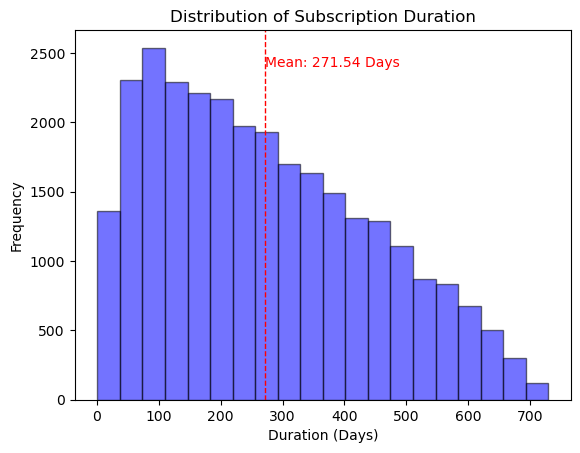

In [143]:
avg_duration = np.mean(sub_duration['SUB_DURATION_DAYS'])
plt.hist(sub_duration['SUB_DURATION_DAYS'], bins=20, color='blue', alpha=0.55, edgecolor='black')
plt.axvline(avg_duration, color='r', linestyle='dashed', linewidth=1)
plt.text(avg_duration, plt.ylim()[1] * 0.9, f'Mean: {avg_duration:.2f} Days', color='r')
plt.title('Distribution of Subscription Duration')
plt.xlabel('Duration (Days)')
plt.ylabel('Frequency')
plt.show()

## Other Data

In [144]:
online_content_consumption = pd.read_csv('/Users/vivianyan/Desktop/Fall2024/1006/Capstone/Data/XYZ_NETWORKS_ONLINE_CONTENT_CONSUMPTION.csv')
online_content_consumption.describe(include='all')

,ID,URL,DATE,SCORE
count,700196,752915,751656,755763.000000
unique,78627,832,747213,NaN
top,237TXUP149,https://www.videosync.com/fallen-crown-the-bat...,2023-12-12T22:09:24+00:00,NaN
freq,46,1801,3,NaN
mean,NaN,NaN,NaN,0.499995
std,NaN,NaN,NaN,0.288810
min,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,0.249840
50%,NaN,NaN,NaN,0.500220
75%,NaN,NaN,NaN,0.750190


In [145]:
online_content_consumption.head()

,ID,URL,DATE,SCORE
0,028ZIWM575,https://www.vodmedia.com/target-locked-episode-10,2023-05-23T17:26:54+00:00,0.44772
1,862RYTF544,https://www.videodirect.com/stormfront-the-fin...,2022-03-03T17:32:02+00:00,NaN
2,467WUAP768,https://www.vodmedia.com/deep-waters-submarine...,2023-08-04T08:57:06+00:00,0.66931
3,765KZVX773,https://www.watchnow.com/deep-waters-submarine...,2023-01-25T12:17:42+00:00,0.88933
4,774ZQUY606,https://www.vodflix.com/target-locked-s2e5,2023-08-03T02:05:50+00:00,0.64074


In [146]:
viewership = pd.read_csv('/Users/vivianyan/Desktop/Fall2024/1006/Capstone/Data/XYZ_NETWORKS_VIEWERSHIP_DATA_1.csv')
viewership.describe(include='all')

,ID,NETWORK,PROGRAM_NAME,GENRE,EVENT_START_TIMESTAMP,DURATION_SECONDS,ROW_NUM
count,468391,697179,704993,585815,697376,696147.000000,706998.000000
unique,78043,116,19073,1097,642130,NaN,NaN
top,032BDMD740,CineQuest,nfl football,news - general,2023-11-26T20:00:00-08:00,NaN,NaN
freq,29,29155,8294,48669,23,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,1970.268751,353499.500000
std,NaN,NaN,NaN,NaN,NaN,2069.181007,204092.887146
min,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000
25%,NaN,NaN,NaN,NaN,NaN,163.000000,176750.250000
50%,NaN,NaN,NaN,NaN,NaN,1258.000000,353499.500000
75%,NaN,NaN,NaN,NaN,NaN,3416.000000,530248.750000


In [147]:
viewership.head()

,ID,NETWORK,PROGRAM_NAME,GENRE,EVENT_START_TIMESTAMP,DURATION_SECONDS,ROW_NUM
0,796ANCE023,bravo,winter house,Reality-TV,2023-11-22T08:52:40-08:00,121.0,1
1,NaN,SilverScreen,Western Trails: The Lone Ranger,Hollywood's golden era films,2022-07-26T08:17:05Z,1837.0,2
2,856OTSW056,the travel channel,portals to hell,instruction/info - travel,2022-06-26T19:00:00-07:00,395.0,3
3,939UQPK765,fox affiliate,tmz,news - other,2022-11-23T19:35:48-08:00,85.0,4
4,510HBMN382,TasteMakers,Bake Off Bonanza,NaN,2022-06-21T19:15:11Z,922.0,5


In [148]:
viewership[viewership.ID=='796ANCE023']

,ID,NETWORK,PROGRAM_NAME,GENRE,EVENT_START_TIMESTAMP,DURATION_SECONDS,ROW_NUM
0,796ANCE023,bravo,winter house,Reality-TV,2023-11-22T08:52:40-08:00,121.0,1
51864,796ANCE023,abc affiliate,wheel of fortune,quiz - give away,2023-04-10T20:00:00-07:00,6.0,51865
68091,796ANCE023,LimeLight,Home Makeover Rescue,"Reality-TV, Lifestyle",2023-11-27T16:12:25Z,5853.0,68092
223699,796ANCE023,lifetime,joel osteen,instruction/info -other,2022-10-09T09:00:19-07:00,498.0,223700
263408,796ANCE023,syfy,land of the lost,comedy,2022-06-05T12:13:09-07:00,112.0,263409
654956,796ANCE023,fox news channel,hannity,news - general,2023-08-18T17:07:50-07:00,25.0,654957
